# Stack Overflow Survey Analysis
Overall goal of this project is to get an understanding what do developers do to have the most successful career.

## 1. Data Preparation

### Load Packages

In [1]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ISLP as islp

In [2]:
# allow for all columns to observe
pd.set_option('display.max_columns',None)

### Create Functions

#### Plot Data
- Pie Graph
- Histogram

In [3]:
# pie graph creation from unique_values()
def pie_graph(df,column):
    # get the value counts index and values for the pie chart
    category = df[column].value_counts().index
    values = df[column].value_counts().values

    # display the pie chart
    plt.figure(figsize=(8,8))
    plt.pie(values,labels=category,autopct='%1.1f%%')
    plt.title(f'Distribution of {column} in Data')
    plt.axis('equal')
    plt.show()

In [4]:
def plot_histogram(data, bins, title, xlabel, ylabel, color='blue', grid=True):

    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color=color, edgecolor='black')
    
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    if grid:
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.show()

#### Probability Functions
- Create distributed data based on distribution function
- Fit data to existing PDF

In [5]:
import random

def generate_and_scale_distribution(distribution_func, dist_params, n, min_desired, max_desired, seed=None):
    """
    Generate n numbers from a specified distribution, scale them to a desired range, and plot the histogram.
    
    :param distribution_func: Function to generate random numbers from the desired distribution (e.g., random.gammavariate)
    :param dist_params: Parameters to pass to the distribution function (as a tuple)
    :param n: Number of values to generate
    :param min_desired: Minimum value of the desired range
    :param max_desired: Maximum value of the desired range
    :param seed: Seed for the random number generator (default is None)
    """
    
    # Set the seed for reproducibility
    if seed is not None:
        random.seed(seed)
    
    # Generate numbers from the specified distribution
    dist_nums = [distribution_func(*dist_params) for _ in range(n)]
    
    # Scale the generated numbers to the desired range
    min_dist = min(dist_nums)
    max_dist = max(dist_nums)
    scaled_nums = [(num - min_dist) * (max_desired - min_desired) / (max_dist - min_dist) + min_desired for num in dist_nums]
    
    # Convert scaled numbers to integers
    int_scaled_nums = [int(num) for num in scaled_nums]

    return int_scaled_nums

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, gamma, uniform,poisson,beta
from sklearn.metrics import mean_absolute_error

def fit_and_plot_distributions(data, distributions, hist_bins=30):
    """
    Fit various distributions to the data, plot the results, and calculate SSE for each distribution.

    Parameters:
    data (array-like): The data to fit the distributions to.
    distributions (list): A list of distributions to fit.
    hist_bins (int): Number of bins for the histogram. Default is 30.

    Returns:
    dict: A dictionary with distribution names as keys and their corresponding SSE values.
    """
    # Create histogram of the data, adjusting 'density' to True for probability density
    counts, bins, _ = plt.hist(data, bins=hist_bins, density=True, color='lightblue', alpha=0.7, label='Histogram of data')

    # Create x values for plotting the PDF
    x = np.linspace(min(data), max(data), 1000)
    mae = {}  # Dictionary to store sum of squared errors for each distribution

    for distribution in distributions:
        # Fit distribution to data
        params = distribution.fit(data)

        # Separate parts of parameters: args (shape), loc (location), scale (scale)
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate the PDF values for each x and for the bin centers
        pdf_values = distribution.pdf(x, *arg, loc=loc, scale=scale)
        estimated_pdf = distribution.pdf(bins[:-1] + np.diff(bins) / 2, *arg, loc=loc, scale=scale)

        # Adjust the estimated PDF by the bin widths to compute the SSE correctly
        bin_widths = np.diff(bins)
        adjusted_pdf = estimated_pdf * bin_widths

        # Calculate the SSE between the observed counts and the estimated PDF values
        mae[distribution.name] = mean_absolute_error(counts,estimated_pdf)

        # Plot the fitted distribution
        plt.plot(x, pdf_values, label=f'{distribution.name} fit')

    # Add plot formatting
    plt.title('Fit results for various distributions')
    plt.xlabel('Data values')
    plt.ylabel('Frequency')
    plt.legend()

    # Display the plot
    plt.show()

    return mae

#### Preprocess Data
- Calculate NA Percentages

In [7]:
def get_na_percentages(data,axis):
    # get the number of rows as the denominator
    if axis == 0:
        num_rows = len(data)

        # get the number of nan values
        nan_counts = data.isna().sum(axis=axis)

        # get the percentage values
        nan_percentage = (nan_counts/num_rows) * 100

    else:
        num_cols = data.shape[1]

        # get the number of nan values
        nan_counts = data.isna().sum(axis=axis)

        # get the percentage values
        nan_percentage = (nan_counts/num_cols) * 100

    return nan_percentage

In [8]:
# convert dev type to dummy variables
def convert_to_dummies(df, columns):
    for column in columns:
        # Create dummy variables
        dummies = pd.get_dummies(df[column])
        
        # Rename columns
        dummies.rename(columns={dummies.columns[1]: column, dummies.columns[0]: f'Not-{column}'}, inplace=True)
        
        # Drop the original column
        df.drop(columns=[column], inplace=True)
        
        # Concatenate the new dummy columns with the original DataFrame
        df = pd.concat([df, dummies], axis=1)
    
    return df

In [9]:
def encode_categorical_column(data_frame, column_name, categories, encoded_values):
    # Create a mapping dictionary using zip
    one_hot_encoding = dict(zip(categories, encoded_values))
    
    # Map the specified column using the created one-hot encoding dictionary
    data_frame[column_name] = data_frame[column_name].map(one_hot_encoding)

    return data_frame

#### Statistical Analysis
- Z-Score

In [10]:
def calculate_z_scores(series):
    mean = np.mean(series)
    std_dev = np.std(series)
    z_scores = (series - mean) / std_dev
    return z_scores

### Data Cleaning

In [11]:
# load the data and set index to the response id
data = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Stack_Overflow_2023/Data/survey_results_public.csv')
data.set_index('ResponseId',inplace=True)
data

,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,TechList,BuyNewTool,Country,Currency,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,AISearchHaveWorkedWith,AISearchWantToWorkWith,AIDevHaveWorkedWith,AIDevWantToWorkWith,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,SOAI,AISelect,AISent,AIAcc,AIBen,AIToolInterested in Using,AIToolCurrently Using,AIToolNot interested in Using,AINextVery different,AINextNeither different nor similar,AINextSomewhat similar,AINextVery similar,AINextSomewhat different,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Knowledge_8,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
ResponseId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,I agree,None of these,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,Formal documentation provided by the owner of ...,Other,18,9,"Senior Executive (C-Suite, VP, etc.)",2 to 9 employees,I have a great deal of influence,Investigate,Start a free trial;Ask developers I know/work ...,United States of America,USD\tUnited States dollar,2.850000e+05,HTML/CSS;JavaScript;Python,Bash/Shell (all shells);C#;Dart;Elixir;GDScrip...,Supabase,Firebase Realtime Database;Supabase,Amazon Web Services (AWS);Netlify;Vercel,Fly.io;Netlify;Render,Next.js;React;Remix;Vue.js,Deno;Elm;Nuxt.js;React;Svelte;Vue.js,Electron;React Native;Tauri,Capacitor;Electron;Tauri;Uno Platform;Xamarin,Docker;Kubernetes;npm;Pip;Vite;Webpack;Yarn,Godot;npm;pnpm;Unity 3D;Unreal Engine;Vite;Web...,Vim;Visual Studio Code,Vim;Visual Studio Code,iOS;iPadOS;MacOS;Windows;Windows Subsystem for...,MacOS;Windows;Windows Subsystem for Linux (WSL),Asana;Basecamp;GitHub Discussions;Jira;Linear;...,GitHub Discussions;Linear;Notion;Trello,Cisco Webex Teams;Discord;Google Chat;Google M...,Discord;Signal;Slack;Zoom,ChatGPT,ChatGPT;Neeva AI,GitHub Copilot,GitHub Copilot,Stack Overflow;Stack Exchange,Daily or almost daily,Yes,A few times per month or weekly,"Yes, definitely","I don't think it's super necessary, but I thin...",Yes,Indifferent,Other (please explain),Somewhat distrust,Learning about a codebase;Writing code;Debuggi...,Writing code;Committing and reviewing code,NaN,NaN,NaN,NaN,NaN,NaN,Yes,People manager,10.0,Strongly agree,Agree,Strongly agree,Agree,Agree,Agree,Agree,Strongly agree,1-2 times a week,10+ times a week,Never,15-30 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,285000.0
3,I agree,I am a developer by profession,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;Professional development or self-paced l...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...

Key features
- 89814 rows (survey results)
- 83 columns (questions)
- Most questions do not have numerical answers

#### Remove Redundant Data
- NA values
- Duplicates

##### NA Values for Columns

In [12]:
# get a percentage count for each column of the number of na values
# the number in the second parameter is the axis
# as it is 0 this is going to look at the columns and find the percentage of na values
na_cols = get_na_percentages(data,0)

# show those with greater than 50% nan values
na_cols[na_cols>50]

LearnCodeCoursesCert                   58.427521
AIDevHaveWorkedWith                    70.954431
AIDevWantToWorkWith                    78.037540
AIAcc                                  56.725422
AIToolInterested in Using              63.241164
AIToolCurrently Using                  59.480400
AIToolNot interested in Using          76.375807
AINextVery different                   85.803507
AINextNeither different nor similar    92.600691
AINextSomewhat similar                 93.005472
AINextVery similar                     97.061132
AINextSomewhat different               73.870874
ICorPM                                 51.036060
WorkExp                                51.135854
Knowledge_1                            52.306468
Knowledge_2                            53.276372
Knowledge_3                            53.132849
Knowledge_4                            53.260675
Knowledge_5                            53.436715
Knowledge_6                            53.444564
Knowledge_7         

These questions seem to belong to certain types of questions, for example the multiple choice questions were missed by about 50% of people. Meanwhile AI questions were ignored by about 70-90% of respondents. These questions were not that relevant to the goals of the investigation anyways. They will be removed apart from:
- Industry
- WorkExperience


In [13]:
# Columns that should not be removed regardless of the percentage of NaN values
cols_to_keep = ['Industry', 'Work Experience']

# make a new dataframe where the na_cols have been dropped
data_na_cols = data.drop(columns=na_cols[na_cols > 50].index.difference(cols_to_keep)).copy()

In [14]:
# look at the number of duplicated survey results as a percentage
(data_na_cols.duplicated().sum() / data_na_cols.shape[0]) * 100

1.3488966630785792

About 1.34% of the data has duplicated values, as it is a survey, it is likely that these are responses which reflect real people with similar responses.

#### Removing Irrelevant Columns
Remove data has responses that are not going to be relevant for the goals of this analysis
- StackOverFlow Colums: SurveyEase, SurveyLength, SOAI, SOComm, NEWOSites, SOVisitFreq, SOAccount, SOPartFreq, TBranch
- AI Columns: AISent, AIBen, AISelect
- Company Specific Columns: BuyNewTool, TechList

In [15]:
# remove as they do not add to the overall analysis of the survey
columns_to_drop = ['SurveyEase','SurveyLength','TBranch','AISent','AIBen','AISelect','SOAI','SOComm',
                   'NEWSOSites', 'SOVisitFreq',	'SOAccount', 'SOPartFreq','BuyNewTool','TechList']

In [16]:
# create a copy of the cleaned data with dropped columns
data_cleaned = data_na_cols.drop(columns=columns_to_drop).copy()
data_cleaned.head(5)

,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,Country,Currency,CompTotal,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysPersonal use,OpSysProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,AISearchHaveWorkedWith,AISearchWantToWorkWith,Industry,ConvertedCompYearly
ResponseId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,I agree,None of these,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,Formal documentation provided by the owner of ...,18,9,"Senior Executive (C-Suite, VP, etc.)",2 to 9 employees,I have a great deal of influence,United States of America,USD\tUnited States dollar,285000.0,HTML/CSS;JavaScript;Python,Bash/Shell (all shells);C#;Dart;Elixir;GDScrip...,Supabase,Firebase Realtime Database;Supabase,Amazon Web Services (AWS);Netlify;Vercel,Fly.io;Netlify;Render,Next.js;React;Remix;Vue.js,Deno;Elm;Nuxt.js;React;Svelte;Vue.js,Electron;React Native;Tauri,Capacitor;Electron;Tauri;Uno Platform;Xamarin,Docker;Kubernetes;npm;Pip;Vite;Webpack;Yarn,Godot;npm;pnpm;Unity 3D;Unreal Engine;Vite;Web...,Vim;Visual Studio Code,Vim;Visual Studio Code,iOS;iPadOS;MacOS;Windows;Windows Subsystem for...,MacOS;Windows;Windows Subsystem for Linux (WSL),Asana;Basecamp;GitHub Discussions;Jira;Linear;...,GitHub Discussions;Linear;Notion;Trello,Cisco Webex Teams;Discord;Google Chat;Google M...,Discord;Signal;Slack;Zoom,ChatGPT,ChatGPT;Neeva AI,"Information Services, IT, Software Development...",285000.0
3,I agree,I am a developer by profession,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;Professional development or self-paced l...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Formal documentation provided by the owner of ...,27,23,"Developer, back-end","5,000 to 9,999 employees",I have some influence,United States of America,USD\tUnited States dollar,250000.0,Bash/Shell (all shells);Go,Haskell;OCaml;Rust,NaN,NaN,Amazon Web Services (AWS);Google Cloud;OpenSta...,NaN,NaN,NaN,NaN,NaN,Cargo;Docker;Kubernetes;Make;Nix,Cargo;Kubernetes;Nix,Emacs;Helix,Emacs;Helix,MacOS;Other Linux-based,MacOS;Other Linux-based,Markdown File;Stack Overflow for Teams,Markdown File,Microsoft Teams;Slack;Zoom,Slack;Zoom,NaN,NaN,"Information Services, IT, Software Development...",250000.0
4,I agree,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Colleague;Friend or family member;Other online...,Formal documentation provided by the owner of ...,12,7,"Developer, front-end",100 to 499 employees,I have some influence,United States of America,USD\tUnited States dollar,156000.0,Bash/Shell (all shells);HTML/CSS;JavaScript;PH...,Bash/Shell (all shells);HTML/CSS;JavaScript;Ru...,PostgreSQL;Redis,PostgreSQL;Redis,Cloudflare;Heroku,Cloudflare;Heroku,Node.js;React;Ruby on Rails;Vue.js;WordPress,Node.js;Ruby on Rails;Vue.js,NaN,NaN,Homebrew;npm;Vite;Webpack;Yarn,Homebrew;npm;Vite,IntelliJ IDEA;Vim;Visual Studio Code;WebStorm,IntelliJ IDEA;Vim;WebStorm,iOS;iPadOS;MacOS,iOS;iPadOS;MacOS,Jira,Jira,Discord;Google Meet;Microsoft Teams;Slack;Zoom,Discord;Google Meet;Slack;

## 2. Survey Respondents Understanding
'data_cleaned' is going to be used as the primary df. This still has all data but has the irrelevant columns to the analysis removed.

Chapter 2 is going to be a brief introduction into the primary demographics of those who responded to the survey. This is going to helpful in understanding potential reasons why the survey responds in the way that it does. For example if there is a high number of respondents who are aged 18-25 they are likely to have learnt to code through online sources rather than those who are aged older than 50.

#### Age Analysis

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

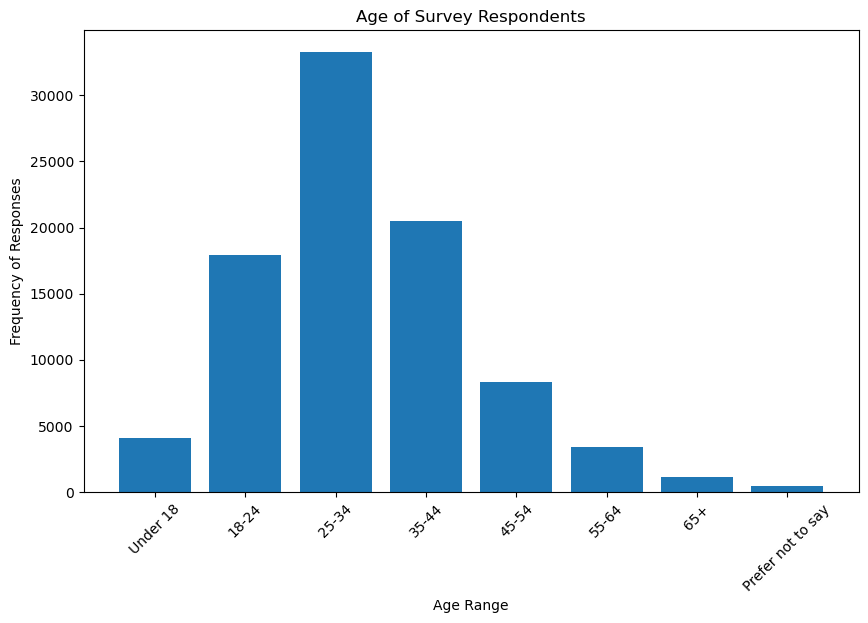

In [18]:
# create an ordered list of ages and their frequencies
age_groups = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+','Prefer not to say']
frequencies = [4128, 17931, 33247, 20532, 8334, 3392, 1171, 449]

# create a bar chart
plt.figure(figsize=(10,6))
plt.bar(age_groups,frequencies)
plt.ylabel('Frequency of Responses')
plt.xlabel('Age Range')
plt.title('Age of Survey Respondents')
plt.xticks(rotation=45)

As age is ordinal we can describe the spread where it seems that it has a uniform distribution with a mean of 25-34 years old for the age of respondents.

#### Respondents use of Coding

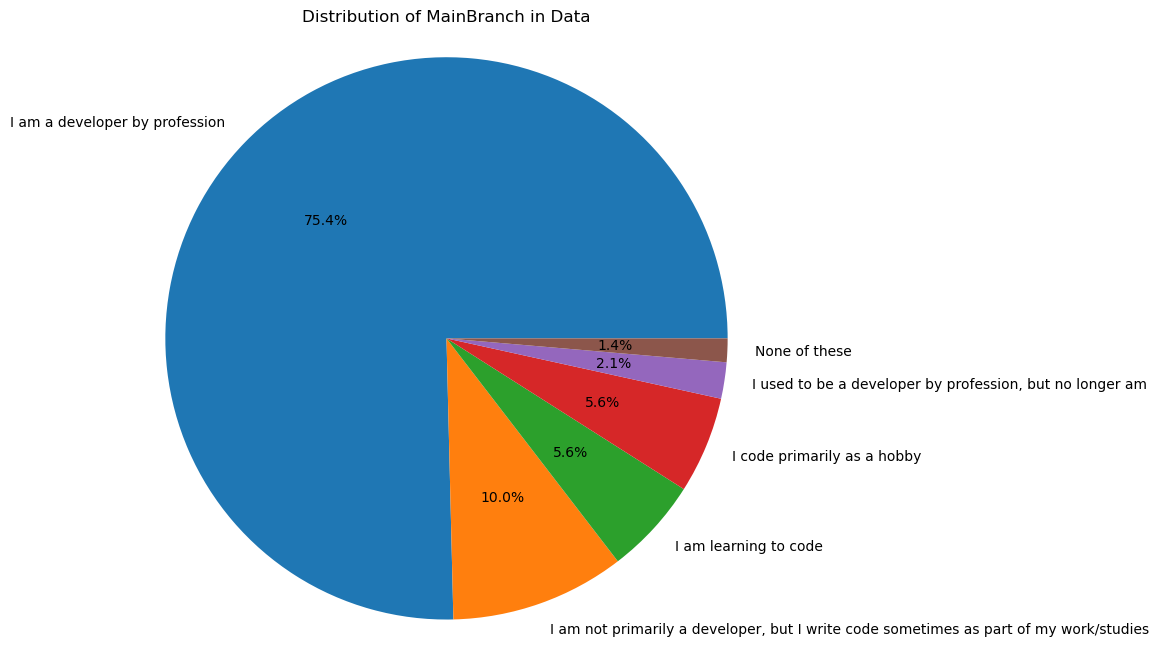

In [19]:
# create a pie chart which describes the distribution of reasons for coding
pie_graph(data_cleaned,'MainBranch')

The majority of respondents are professionals who earn money for their skills in code. 

### Education Level

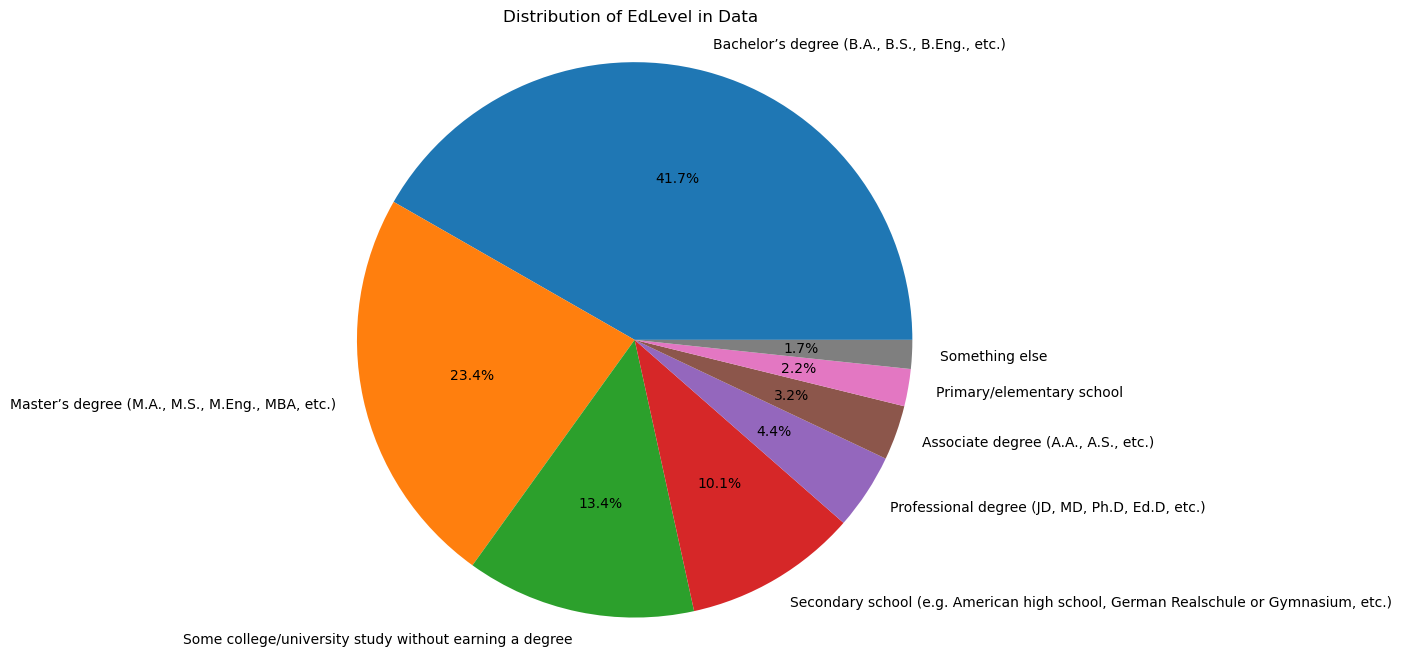

In [20]:
# create a pie chart for the level of education respondents have achieved
pie_graph(data_cleaned,'EdLevel')

2/3 of respondents have atleast a bachelors degree, this is obviously a very high value in comparison to global numbers. This suggests that the data is going to be skewed to those who are financially invested in harnessing a career to do with data/code.

Text(0.5, 1.0, 'Top 10 Country of Respondents in Survey')

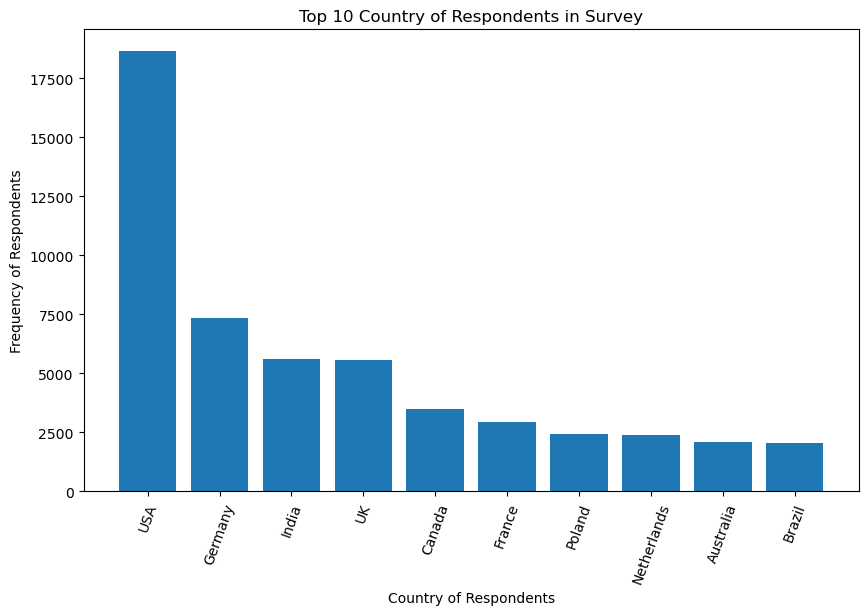

In [21]:
# get the y values of the top 10 countries
country_respondents = data_cleaned['Country'].value_counts().head(10)

# rename the countries to their shorten version
country_respondents.index = ['USA','Germany','India','UK','Canada','France','Poland','Netherlands','Australia','Brazil']

# create a bar chart of the top 10 countries
plt.figure(figsize=(10,6))
plt.bar(country_respondents.index,country_respondents.values)
plt.xticks(rotation=70)
plt.ylabel('Frequency of Respondents')
plt.xlabel('Country of Respondents')
plt.title('Top 10 Country of Respondents in Survey')

The majority of respondents are in the US. The rest of the countries belong mainly to Europe however Brazil, Australia, India and Canada are also in there responses.

## 3. Exploratory Data Analysis

### Salary Investigation
Create a deep understanding of salary distributions based on the following questions
1. Which country is the best for expecting a higher salary
2. How much do people with different education levels recieve
3. Which industry returns the most highest salary

In [22]:
# remove 'CompTotal' as it creates a lot of bottlenecks in understanding the salaries earned by respondents
data_cleaned.drop(columns='CompTotal',inplace=True)

#### 3.1 Salaries in Different Countries

##### Remove Low Responding Countries
For accuracy amongst inferential data collected, removing the countries with less than 10 respondents is going to ensure that the generalised values such as mean or median is accurately reflected by a high number of respondents to counteract outliers. 

Any analysis to do with countries is going to remove the countries as listed below.

In [23]:
# get a count of respondents with different countries
country_respondents_count = data_cleaned.groupby('Country')['ConvertedCompYearly'].count()

# create mask which has less than 10 respondents per country
country_sub_10_respondents_mask = country_respondents_count > 10

# extract the list of countries with less than 10 respondents
country_sub_10_respondents_list = country_sub_10_respondents_mask[~country_sub_10_respondents_mask].index.tolist()

# output the countries that have been removed
np.array(country_sub_10_respondents_list)

array(['Andorra', 'Angola', 'Antigua and Barbuda', 'Bahamas', 'Bahrain',
       'Barbados', 'Belize', 'Benin', 'Bhutan', 'Botswana',
       'Brunei Darussalam', 'Burkina Faso', 'Burundi', 'Cameroon',
       'Cape Verde', 'Central African Republic',
       'Congo, Republic of the...', "Côte d'Ivoire",
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Djibouti', 'Dominica', 'Fiji',
       'Gabon', 'Grenada', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti',
       'Isle of Man', 'Jamaica', 'Kosovo', 'Kuwait',
       "Lao People's Democratic Republic", 'Lesotho', 'Liberia',
       'Libyan Arab Jamahiriya', 'Liechtenstein', 'Madagascar', 'Malawi',
       'Maldives', 'Mali', 'Marshall Islands', 'Mauritania', 'Monaco',
       'Mozambique', 'Namibia', 'Niger', 'North Korea', 'Oman', 'Palau',
       'Qatar', 'Rwanda', 'Saint Kitts and Nevis', 'Saint Lucia',
       'Saint Vincent and the Grenadines', 'Samoa', 'San Marino',
       'Senegal', 'Sierra Leone', 

The countries listed above that are going to be removed consist of about 650 respondents from Asia, Europe, Oceania, the Middle East and the Carribbean. It is likely that the people who use the website that the survey was collected from does not have as high of an outreach to these countries. Removing this data is going to be useful for understanding the spread of salaries.

##### Countries with Highest Salaries
- Look at the spread, highest and lowest earning countries for salary
- Incorporate median income salary data from WorldPopulation (documentation can be found in report file)

In [24]:
# create a list of those countries who have greater than 10 respondents
countries_10_plus_respondents = country_sub_10_respondents_mask[country_sub_10_respondents_mask].index.tolist()

# create a dataframe with those countries with greater than 10 respondents
countries_ten_plus_df = data_cleaned[data_cleaned['Country'].isin(countries_10_plus_respondents)]

# create a median of each country
median_salary_survey_country = countries_ten_plus_df.groupby('Country').median()

# sort the data
median_salary_survey_country_sorted = median_salary_survey_country.sort_values(by='ConvertedCompYearly',ascending=False)

# output the top 5
print(f'Top 10 Countries Median Salary:{median_salary_survey_country_sorted.head(10)}')

Top 10 Countries Median Salary:                          ConvertedCompYearly
Country                                      
United States of America             150000.0
Switzerland                          122064.5
Israel                               112257.0
Luxembourg                           107090.0
Nomadic                              102000.0
Ireland                               96381.0
Australia                             95851.0
Denmark                               93173.0
Canada                                89222.0
Singapore                             85228.0


The United States of America stands out as an outler with a median income of 150k a year with Switzerland with a median value almost 30k less. The use of the median income reduces the effects of individual outliers who may have far higher incomes which would skew the data. 

Also observe that there is a country called Nomadic, this is not commonly known as a single country so lets investigate:

In [25]:
# look at the currency to try to understand where 'Nomadic' is
data_cleaned[data_cleaned['Country'] == 'Nomadic']['Currency'].value_counts()

USD\tUnited States dollar     19
EUR European Euro             11
ZMW Zambian kwacha             5
DKK\tDanish krone              1
MKD\tMacedonian denar          1
MZN\tMozambican metical        1
KYD\tCayman Islands dollar     1
BGN\tBulgarian lev             1
INR\tIndian rupee              1
YER\tYemeni rial               1
Name: Currency, dtype: int64

The majority currency is in USD and EUR so this does not help much. I am not going to remove the data from the df but it is important to take note.

The next question is: do these respondents get paid less on average by their country or is it due to the lack of payment for these jobs in the countries. To answer this, import global median income values. Let's compare the position of the country based on their survey ranking for median salary compared with their global ranking.

##### Nations with highest Global Median Income

In [26]:
# download median income by country to see how incomes compare
global_median_income = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Stack Overflow Survey Analysis/imported data/median-income-by-country-2024.csv')

# drop na values
global_median_income = global_median_income[['country','medianIncomeByCountry_medianIncome']].dropna()

# rename columns
global_median_income.rename(columns={'medianIncomeByCountry_medianIncome':'Global Median Salary'},inplace=True)

# output data
global_median_income

,country,Global Median Salary
2,United States,24327.0
3,Pakistan,1399.0
4,Nigeria,825.0
5,Brazil,4230.0
6,Bangladesh,1131.0
...,...,...
156,Kiribati,1489.0
157,Micronesia,1413.0
158,Tonga,2782.0
159,Seychelles,7118.0


In [27]:
# sort by median income
global_median_income_sorted = global_median_income.sort_values(by='Global Median Salary',ascending=False)

# give a number ranking as a new column
global_median_income_sorted['Ranking Global Median Salary'] = range(1,len(global_median_income_sorted)+1)

global_median_income_sorted.set_index('country',inplace=True)

global_median_income_sorted

,Global Median Salary,Ranking Global Median Salary
country,,
Luxembourg,28382.0,1
United Arab Emirates,26324.0,2
United States,24327.0,3
Norway,23835.0,4
Switzerland,23488.0,5
...,...,...
Central African Republic,491.0,155
Malawi,484.0,156
Burundi,475.0,157


In [28]:
# rename column
median_salary_survey_country_sorted.rename(columns={'ConvertedCompYearly':'Survey Median Salary'},inplace=True)

# create ranking
median_salary_survey_country_sorted['Ranking Survey Median Salary'] = range(1,len(median_salary_survey_country)+1)

# reset index to replace values in country column
median_salary_survey_country_sorted.reset_index(inplace=True)

# replace values so that they can be similar with other df
median_salary_survey_country_sorted['Country'] = median_salary_survey_country_sorted['Country'].replace({
    'United States of America': 'United States',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom'
})

# set country to index so that it can join with global median df
median_salary_survey_country_sorted.set_index('Country',inplace=True)

In [29]:
# merge the two dataframes to compare rankings with one another
salary_comparison_df = median_salary_survey_country_sorted.merge(global_median_income_sorted,left_index=True,right_index=True)

# show the top 10
salary_comparison_df.sort_values(by='Survey Median Salary',ascending=False).head(10)

,Survey Median Salary,Ranking Survey Median Salary,Global Median Salary,Ranking Global Median Salary
United States,150000.0,1,24327.0,3
Switzerland,122064.5,2,23488.0,5
Israel,112257.0,3,12282.0,30
Luxembourg,107090.0,4,28382.0,1
Ireland,96381.0,6,17962.0,17
Australia,95851.0,7,19363.0,12
Denmark,93173.0,8,20593.0,9
Canada,89222.0,9,20550.0,10
Iceland,85182.0,11,20630.0,8
United Kingdom,81931.0,12,16907.0,19


Notice that the median salary for survey respondents seem to perform overall much better than their global median salary. This suggests that these countries such as Israel, Ireland, Australia and United Kingdom are paying their Data jobs at a better rate than other jobs.

##### Spread of Nations Pay for Data Roles

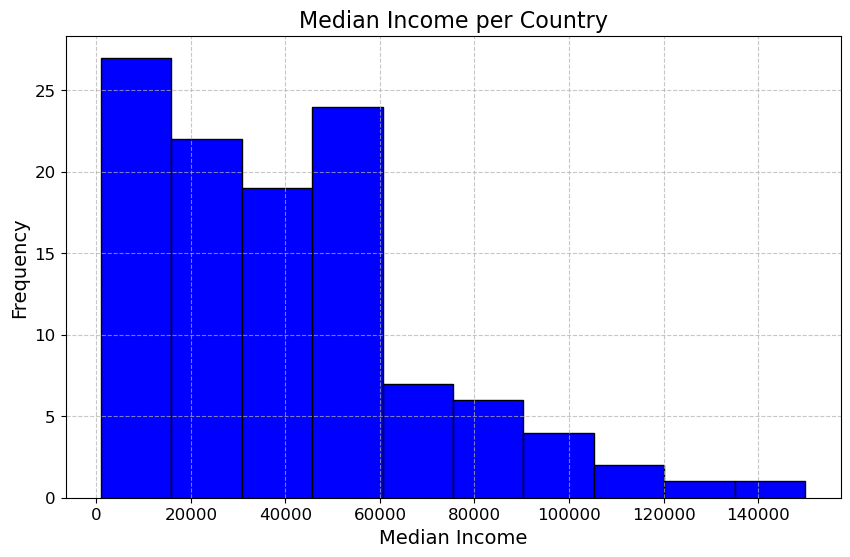

In [30]:
# plot all the countries median salaries
plot_histogram(median_salary_survey_country,10,'Median Income per Country','Median Income','Frequency')

Notice that only a small percentage of countries are paying their Data roles at greater than 60k a year. Meanwhile some nations are recieving between 0-20k which is likely due to the lower median salary of these nations, let's look at the opposite end of the survey salary vs global median salary rankings

In [31]:
# show the lowest 20 countries for median pay
salary_comparison_df.tail(20).sort_values(by='Survey Median Salary',ascending=True)

,Survey Median Salary,Ranking Survey Median Salary,Global Median Salary,Ranking Global Median Salary
Myanmar,2385.0,112,1909.0,102
Ghana,4437.0,111,1779.0,104
Pakistan,5959.0,110,1399.0,114
Nepal,6063.0,109,1155.0,121
Bangladesh,6508.0,107,1131.0,123
Ethiopia,7004.5,106,907.0,130
Egypt,7954.0,103,1485.0,110
Tunisia,8030.0,102,3366.0,69
Algeria,8782.0,101,2612.0,85
Uganda,9654.0,100,804.0,139


The comparison also shows that those countries with lower Median salaries in the survey are also those with lower Global Median Salaries. Notice that those in Data role are still earning far higher than the average for every country. Proving that these roles are lucaritve in every country. However this highlights an even greater wealth distribution problem amonst nations as a majority of countries typical person is earning less than 60k a year while a typical person in the US is earnign 150k a year.

##### Compare Global Income level with Survey Data
As it is difficult to generalise countries data for future predictive analysis, import data by the world bank and compare how the low income, lower middle income, upperm iddle income and high income compares with the median salaries of countries. The goal is to then have 4 different nation types for their salaries to then be included in a predictive model.

In [73]:
# import the data from excel
income_class = pd.read_excel('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Stack Overflow Survey Analysis/imported data/CLASS.xlsx')

# choose the specific columns that are relevant
income_class = income_class[['Economy','Income group']]

income_class.rename(columns={'Income group':'Income Level (imported data)'},inplace=True)

# set the index to economy (country)
income_class.set_index('Economy',inplace=True)

# output the data
income_class

,Income Level (imported data)
Economy,
Aruba,High income
Afghanistan,Low income
Angola,Lower middle income
Albania,Upper middle income
Andorra,High income
...,...
Sub-Saharan Africa,NaN
Sub-Saharan Africa (excluding high income),NaN
Sub-Saharan Africa (IDA & IBRD),NaN


In [77]:

# Assuming median_salary_survey_country is a DataFrame containing 'ConvertedCompYearly' column

# Calculate max and min values
median_salary_country_max_value = median_salary_survey_country['ConvertedCompYearly'].max()
median_salary_country_min_value = median_salary_survey_country['ConvertedCompYearly'].min()

# Calculate the range (difference between max and min)
min_max_difference_median_salary_country = median_salary_country_max_value - median_salary_country_min_value

# Normalize salaries by dividing each by the range
median_salary_survey_country_min_max = median_salary_survey_country['ConvertedCompYearly'] / min_max_difference_median_salary_country

# Calculate percentiles
salary_percentiles = np.percentile(median_salary_survey_country_min_max, [25, 50, 75, 100])

# Define income classes based on percentiles
income_class_low = salary_percentiles[0]
income_class_low_middle = salary_percentiles[1]
income_class_middle = salary_percentiles[2]
income_class_high = salary_percentiles[3]

# Function to classify income based on normalized salary
def classify_income(salary):
    if salary <= income_class_low:
        return 'Low income'
    elif salary <= income_class_low_middle:
        return 'Lower middle Income'
    elif salary <= income_class_middle:
        return 'Upper middle Income'
    else:
        return 'High income'

In [78]:
# Apply the classification function to each element in the Series
income_groups = median_salary_survey_country_min_max.apply(classify_income)

# Add the income_groups to your DataFrame for further analysis if needed
median_salary_survey_country['Survey IncomeGroup'] = income_groups

income_group_comparison = median_salary_survey_country.merge(income_class,left_index=True,right_index=True)
income_group_comparison

,ConvertedCompYearly,Survey IncomeGroup,Income Level (imported data)
Afghanistan,915.0,Low income,Low income
Albania,10741.0,Low income,Upper middle income
Algeria,8782.0,Low income,Lower middle income
Argentina,30000.0,Lower middle Income,Upper middle income
Armenia,52054.0,Upper middle Income,Upper middle income
...,...,...,...
Uganda,9654.0,Low income,Low income
Ukraine,44420.0,Upper middle Income,Lower middle income
United Arab Emirates,61896.0,High income,High income
Uruguay,51592.0,Upper middle Income,High income


#### 3.2 Salaries with Different Education Levels
From looking at the inital demographics, it is clear that a majority of those who answered this have some type of degree. Let's try to see how much on average an individual will make as a result of obtaining a new degree

In [35]:
# rename the list of EdLevel to be more simple
ed_level_unique = data_cleaned['EdLevel'].dropna().unique()

# create a new list of names for different education level
ed_level_unique_new = ["Bachelor's degree",'Some university',"Master's degree",'Primrary/elemntary school',
                   'Professional degree','Associate degree','Secondary school','Something else']

# using the dict(zip) allows you to replace the old list with a mapping of new values
ed_level_map = dict(zip(ed_level_unique,ed_level_unique_new))

# replace the old values with the new ones
data_cleaned['EdLevel'] = data_cleaned['EdLevel'].replace(ed_level_map)

# observe the new unique values
data_cleaned['EdLevel'].unique()

array([nan, "Bachelor's degree", 'Some university', "Master's degree",
       'Primrary/elemntary school', 'Professional degree',
       'Associate degree', 'Secondary school', 'Something else'],
      dtype=object)

In [36]:
# group by different education levels
median_salary_survey_edlevel = data_cleaned.groupby('EdLevel')['ConvertedCompYearly'].median()

In [37]:
# this data can be sorted to be ordinal values
# use the same order from above to replace 
ed_level_numeric = [5,3,6,1,7,4,2,0]

# use the same dict(zip) from before to replace the categorical variable as a one hot encoded variable
ed_level_one_hot_map = dict(zip(ed_level_unique_new,ed_level_numeric))

# create a dataframe which replaces categorical variables with their one hot encoded values
# define it as numerical as the goal is to only have numeric values
data_cleaned_numeric = data_cleaned.copy()

# change the 'EdLevel' to the mapping values of the one hot encoded values
data_cleaned_numeric['EdLevel'] = data_cleaned_numeric['EdLevel'].replace(ed_level_one_hot_map)

# ensure that the new values are clearly observed in the df
data_cleaned_numeric['EdLevel'].unique()

array([nan,  5.,  3.,  6.,  1.,  7.,  4.,  2.,  0.])

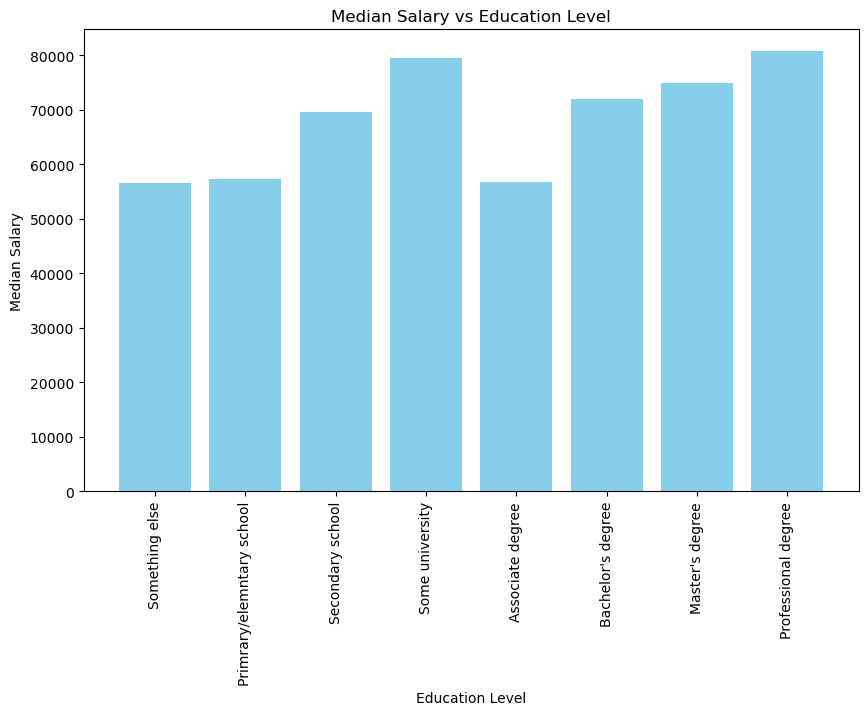

In [38]:
# create a dataframe that orders the data based on education
# the top values will start with PhD's then work down to some other experience of school education
data_cleaned_sorted_education = data_cleaned_numeric.sort_values(by='EdLevel',ascending=False)

# create a bar chart to explain the salary comparison with different degrees
plt.figure(figsize=(10, 6))
plt.bar(ed_level_numeric, median_salary_survey_edlevel, color='skyblue')
plt.title('Median Salary vs Education Level')
plt.xlabel('Education Level')
plt.ylabel('Median Salary')
plt.xticks(ed_level_numeric, ed_level_unique_new, rotation=90)  # Set x-axis labels and rotation
plt.show()

In [39]:
data_cleaned[data_cleaned['ConvertedCompYearly']<100]['EdLevel'].value_counts()

Bachelor's degree            115
Master's degree               58
Some university               36
Secondary school              14
Professional degree           11
Primrary/elemntary school      9
Something else                 6
Associate degree               6
Name: EdLevel, dtype: int64

In [40]:
mean_salary_survey_edlevel = data_cleaned.groupby('EdLevel').mean()
mean_salary_survey_edlevel

,ConvertedCompYearly
EdLevel,
Associate degree,89411.714912
Bachelor's degree,103270.333363
Master's degree,96567.105941
Primrary/elemntary school,340393.324324
Professional degree,190433.547236
Secondary school,79802.163209
Some university,88592.100990
Something else,68804.231855


You can observe that the median value does not change much across different levels of education especially for those going from anything greater than secondary education all the way to a professional degree.

## 3. What contributes to a higher earning respondent

### Feature Selection
The following columns are going to be useful parameters to look at when comparing with yearly income
- EdLevel
- YearsCodePro
- Years Code
- DevType
- OrgSize
- Country
- Industry
- ConvertedCompYearly

In [41]:
# create new dataframe
earnings_data = data_cleaned[['EdLevel','YearsCodePro','YearsCode','DevType','OrgSize','Country','Industry','ConvertedCompYearly']]
earnings_data

,EdLevel,YearsCodePro,YearsCode,DevType,OrgSize,Country,Industry,ConvertedCompYearly
ResponseId,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bachelor's degree,9,18,"Senior Executive (C-Suite, VP, etc.)",2 to 9 employees,United States of America,"Information Services, IT, Software Development...",285000.0
3,Bachelor's degree,23,27,"Developer, back-end","5,000 to 9,999 employees",United States of America,"Information Services, IT, Software Development...",250000.0
4,Bachelor's degree,7,12,"Developer, front-end",100 to 499 employees,United States of America,NaN,156000.0
5,Bachelor's degree,4,6,"Developer, full-stack",20 to 99 employees,Philippines,Other,23456.0
...,...,...,...,...,...,...,...,...
89180,Associate degree,5,20,"Developer, front-end",100 to 499 employees,Brazil,NaN,NaN
89181,Bachelor's degree,NaN,5,"Developer, back-end",NaN,Romania,NaN,NaN
89182,Something else,NaN,10,NaN,NaN,Israel,NaN,NaN


### Data Cleaning
As the goal for this section is to understand what leads to respondents with a high income. Remove any of the respondents who answered 'ConvertedCompYearly' as NA.

In [42]:
# collect those who responses to 'ConvertedCompYearly' was na
# create a mask to remove from the 'earnings_data' df
na_for_salary = earnings_data['ConvertedCompYearly'].isna()

# remove those who had na responses for 'CompTotal' and 'ConvertedCompYearly'
earnings_data = earnings_data[~na_for_salary]

# return dataframe
# this dataframe is going to be used for analysis
earnings_data

,EdLevel,YearsCodePro,YearsCode,DevType,OrgSize,Country,Industry,ConvertedCompYearly
ResponseId,,,,,,,,
2,Bachelor's degree,9,18,"Senior Executive (C-Suite, VP, etc.)",2 to 9 employees,United States of America,"Information Services, IT, Software Development...",285000.0
3,Bachelor's degree,23,27,"Developer, back-end","5,000 to 9,999 employees",United States of America,"Information Services, IT, Software Development...",250000.0
4,Bachelor's degree,7,12,"Developer, front-end",100 to 499 employees,United States of America,NaN,156000.0
5,Bachelor's degree,4,6,"Developer, full-stack",20 to 99 employees,Philippines,Other,23456.0
6,Some university,21,21,"Developer, back-end",100 to 499 employees,United Kingdom of Great Britain and Northern I...,Other,96828.0
...,...,...,...,...,...,...,...,...
89163,Master's degree,24,30,"Developer, back-end","5,000 to 9,999 employees",Brazil,"Information Services, IT, Software Development...",50719.0
89167,Some university,2,7,"Developer, full-stack",20 to 99 employees,Armenia,Financial Services,16917.0
89168,Bachelor's degree,2,6,"Developer, mobile",20 to 99 employees,India,Retail and Consumer Services,15752.0


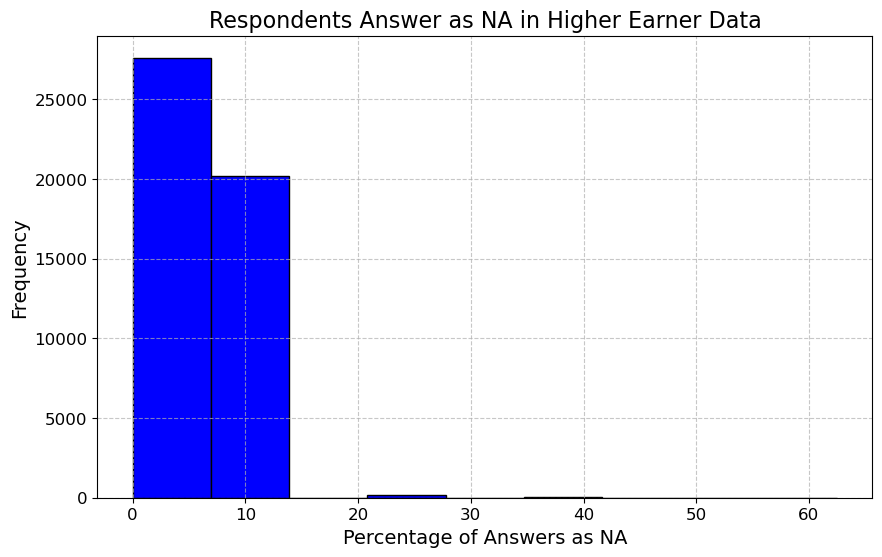

In [43]:
# create a percentage value of na values as responses for the df
earner_data_na_responses = get_na_percentages(earnings_data,1)

# plot the data
plot_histogram(earner_data_na_responses,9,'Respondents Answer as NA in Higher Earner Data','Percentage of Answers as NA','Frequency')

Most of the respondents have very few columns with NA as responses, with none going above about 50% which means that the data has been processed to have enough information to draw insightful conclusions

### One-Hot Encoding DF

In [44]:
# create a copy of the new dataframe which will have one hot encoded values
earnings_data_one_hot = earnings_data.copy()

In [45]:
# create a list of the columns that need to changed to one hot encoded
earnings_data.select_dtypes(include=['object']).columns.tolist()

['EdLevel',
 'YearsCodePro',
 'YearsCode',
 'DevType',
 'OrgSize',
 'Country',
 'Industry']

#### EdLevel
This data represents the type of official education that has been done by the respondent

In [46]:
# output the unique values
education_levels = earnings_data['EdLevel'].unique()
education_levels

array(["Bachelor's degree", 'Some university', "Master's degree",
       'Primrary/elemntary school', 'Professional degree',
       'Associate degree', 'Secondary school', 'Something else'],
      dtype=object)

As this is something that has an order, allocate the following values with their respective numbers
- 'Something else': 0
- 'Primary/elemantary': 1
- 'Secondary school': 2
- 'Some college/university study without earning a degree': 3
- 'Associate degree': 4
- 'Bachelor's degree': 5
- 'Master's degree': 6
- 'Professional degree': 7

In [47]:
# create the list of numbers based on the values in earnings data
ed_level_one_hot = [0,1,2,3,4,5,6,7]
ed_level = ['Something else',
            'Primary/elementary school',
            'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
            'Some college/university study without earning a degree',
            'Associate degree (A.A., A.S., etc.)',
            'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
            'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
            'Professional degree (JD, MD, Ph.D, Ed.D, etc.)']

# Create a mapping from ed_level to ed_level_one_hot
ed_level_mapping = dict(zip(ed_level, ed_level_one_hot))

earnings_data_one_hot['EdLevel'] = earnings_data['EdLevel'].map(ed_level_mapping)
earnings_data_one_hot

,EdLevel,YearsCodePro,YearsCode,DevType,OrgSize,Country,Industry,ConvertedCompYearly
ResponseId,,,,,,,,
2,NaN,9,18,"Senior Executive (C-Suite, VP, etc.)",2 to 9 employees,United States of America,"Information Services, IT, Software Development...",285000.0
3,NaN,23,27,"Developer, back-end","5,000 to 9,999 employees",United States of America,"Information Services, IT, Software Development...",250000.0
4,NaN,7,12,"Developer, front-end",100 to 499 employees,United States of America,NaN,156000.0
5,NaN,4,6,"Developer, full-stack",20 to 99 employees,Philippines,Other,23456.0
6,NaN,21,21,"Developer, back-end",100 to 499 employees,United Kingdom of Great Britain and Northern I...,Other,96828.0
...,...,...,...,...,...,...,...,...
89163,NaN,24,30,"Developer, back-end","5,000 to 9,999 employees",Brazil,"Information Services, IT, Software Development...",50719.0
89167,NaN,2,7,"Developer, full-stack",20 to 99 employees,Armenia,Financial Services,16917.0
89168,NaN,2,6,"Developer, mobile",20 to 99 employees,India,Retail and Consumer Services,15752.0


#### OrgSize
Use the numerical increases to represent the size of the company increasing.

In [48]:
earnings_data['OrgSize'].unique()

array(['2 to 9 employees', '5,000 to 9,999 employees',
       '100 to 499 employees', '20 to 99 employees',
       '1,000 to 4,999 employees', '10 to 19 employees',
       '10,000 or more employees', '500 to 999 employees',
       'Just me - I am a freelancer, sole proprietor, etc.',
       'I don’t know', nan], dtype=object)

In [49]:
org_size_one_hot = [0,1,2,3,4,5,6,7,8,9,10,11]
org_size = ["I don't know",
            'Just me - I am a freelancer, sole proprietor, etc.',
            '2 to 9 employees',
            '10 to 19 employees',
            '20 to 99 employees',
            '100 to 499 employees',
            '500 to 999 employees',
            '1,000 to 4,999 employees',
            '5,000 to 9,999 employees',
            '10,000 or more employees']

org_size_mapping = dict(zip(org_size, org_size_one_hot))
earnings_data_one_hot['OrgSize'] = earnings_data['OrgSize'].map(org_size_mapping)

earnings_data_one_hot

,EdLevel,YearsCodePro,YearsCode,DevType,OrgSize,Country,Industry,ConvertedCompYearly
ResponseId,,,,,,,,
2,NaN,9,18,"Senior Executive (C-Suite, VP, etc.)",2.0,United States of America,"Information Services, IT, Software Development...",285000.0
3,NaN,23,27,"Developer, back-end",8.0,United States of America,"Information Services, IT, Software Development...",250000.0
4,NaN,7,12,"Developer, front-end",5.0,United States of America,NaN,156000.0
5,NaN,4,6,"Developer, full-stack",4.0,Philippines,Other,23456.0
6,NaN,21,21,"Developer, back-end",5.0,United Kingdom of Great Britain and Northern I...,Other,96828.0
...,...,...,...,...,...,...,...,...
89163,NaN,24,30,"Developer, back-end",8.0,Brazil,"Information Services, IT, Software Development...",50719.0
89167,NaN,2,7,"Developer, full-stack",4.0,Armenia,Financial Services,16917.0
89168,NaN,2,6,"Developer, mobile",4.0,India,Retail and Consumer Services,15752.0


#### DevType
To reduce the complicated nature of having 33 different parameter outputs, these can be reduced to more broad terms such as 
- Software Developer
- Data and AI Professionals
- Engineering and Operations
- Management and Leadership
- Academic and Research
- Other

In [50]:
# get all of the unique values
earnings_data['DevType'].unique()

array(['Senior Executive (C-Suite, VP, etc.)', 'Developer, back-end',
       'Developer, front-end', 'Developer, full-stack',
       'System administrator', 'Developer, QA or test', 'Designer',
       'Data scientist or machine learning specialist',
       'Data or business analyst', 'Security professional',
       'Research & Development role', 'Developer, mobile',
       'Database administrator',
       'Developer, embedded applications or devices',
       'Developer, desktop or enterprise applications', 'Engineer, data',
       'Product manager', 'Academic researcher',
       'Cloud infrastructure engineer', 'Other (please specify):',
       'Developer Experience', 'Engineering manager', 'DevOps specialist',
       'Engineer, site reliability', 'Project manager', 'Blockchain', nan,
       'Developer, game or graphics', 'Developer Advocate',
       'Hardware Engineer', 'Educator', 'Scientist',
       'Marketing or sales professional', 'Student'], dtype=object)

In [51]:
# create a dictionary to create new Developer Types
# Define the mapping dictionary
dev_type_mapping = {
    'Developer, full-stack': 'Software Developer',
    'Developer, back-end': 'Software Developer',
    'Developer, front-end': 'Software Developer',
    'Developer, desktop or enterprise applications': 'Software Developer',
    'Developer, mobile': 'Software Developer',
    'Developer, embedded applications or devices': 'Software Developer',
    'Developer, game or graphics': 'Software Developer',
    'Developer, QA or test': 'Software Developer',

    'Data scientist or machine learning specialist': 'Data and AI Professionals',
    'Engineer, data': 'Data and AI Professionals',
    'Data or business analyst': 'Data and AI Professionals',

    'DevOps specialist': 'Engineering and Operations',
    'System administrator': 'Engineering and Operations',
    'Engineer, site reliability': 'Engineering and Operations',
    'Cloud infrastructure engineer': 'Engineering and Operations',
    'Security professional': 'Engineering and Operations',
    'Blockchain': 'Engineering and Operations',
    'Hardware Engineer': 'Engineering and Operations',
    'Database administrator': 'Engineering and Operations',

    'Engineering manager': 'Management and Leadership',
    'Senior Executive (C-Suite, VP, etc.)': 'Management and Leadership',
    'Project manager': 'Management and Leadership',
    'Product manager': 'Management and Leadership',

    'Academic researcher': 'Academic and Research',
    'Scientist': 'Academic and Research',
    'Research & Development role': 'Academic and Research',
    'Student': 'Academic and Research',

    'Developer Advocate': 'Others',
    'Developer Experience': 'Others',
    'Designer': 'Others',
    'Educator': 'Others',
    'Marketing or sales professional': 'Others',
    'Other (please specify):': 'Others'
}

In [52]:
# function to map multiple dev types in a single row
def map_dev_type(dev_type_str):
    dev_types = dev_type_str.split('; ')
    mapped_types = [dev_type_mapping.get(dev_type, 'Others') for dev_type in dev_types]
    return '; '.join(mapped_types)

# apply the mapping to the DevType column
earnings_data_one_hot['DevType'] = earnings_data['DevType'].dropna().apply(map_dev_type)

earnings_data_one_hot

,EdLevel,YearsCodePro,YearsCode,DevType,OrgSize,Country,Industry,ConvertedCompYearly
ResponseId,,,,,,,,
2,NaN,9,18,Management and Leadership,2.0,United States of America,"Information Services, IT, Software Development...",285000.0
3,NaN,23,27,Software Developer,8.0,United States of America,"Information Services, IT, Software Development...",250000.0
4,NaN,7,12,Software Developer,5.0,United States of America,NaN,156000.0
5,NaN,4,6,Software Developer,4.0,Philippines,Other,23456.0
6,NaN,21,21,Software Developer,5.0,United Kingdom of Great Britain and Northern I...,Other,96828.0
...,...,...,...,...,...,...,...,...
89163,NaN,24,30,Software Developer,8.0,Brazil,"Information Services, IT, Software Development...",50719.0
89167,NaN,2,7,Software Developer,4.0,Armenia,Financial Services,16917.0
89168,NaN,2,6,Software Developer,4.0,India,Retail and Consumer Services,15752.0


#### Country
Due to the number of countries and the higher concentration create a variable that is US/Not US

In [53]:
usa_mask = earnings_data_one_hot['Country']=='United States of America'
usa_mask

ResponseId
2         True
3         True
4         True
5        False
6        False
         ...  
89163    False
89167    False
89168    False
89171    False
89172    False
Name: Country, Length: 48019, dtype: bool

In [54]:
earnings_data_one_hot['Country'][usa_mask] = 1
earnings_data_one_hot['Country'][~usa_mask] = 0

earnings_data_one_hot

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_33707/3302318340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_data_one_hot['Country'][usa_mask] = 1
/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_33707/3302318340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_data_one_hot['Country'][~usa_mask] = 0


,EdLevel,YearsCodePro,YearsCode,DevType,OrgSize,Country,Industry,ConvertedCompYearly
ResponseId,,,,,,,,
2,NaN,9,18,Management and Leadership,2.0,1,"Information Services, IT, Software Development...",285000.0
3,NaN,23,27,Software Developer,8.0,1,"Information Services, IT, Software Development...",250000.0
4,NaN,7,12,Software Developer,5.0,1,NaN,156000.0
5,NaN,4,6,Software Developer,4.0,0,Other,23456.0
6,NaN,21,21,Software Developer,5.0,0,Other,96828.0
...,...,...,...,...,...,...,...,...
89163,NaN,24,30,Software Developer,8.0,0,"Information Services, IT, Software Development...",50719.0
89167,NaN,2,7,Software Developer,4.0,0,Financial Services,16917.0
89168,NaN,2,6,Software Developer,4.0,0,Retail and Consumer Services,15752.0


In [55]:
linear_regression_data_salary = convert_to_dummies(earnings_data_one_hot,['DevType','Industry'])

### Data Pre-Processing

In [56]:
# observe the different data types
earnings_data.dtypes

EdLevel                 object
YearsCodePro            object
YearsCode               object
DevType                 object
OrgSize                 object
Country                 object
Industry                object
ConvertedCompYearly    float64
dtype: object

#### Transforming 'YearsCode' and 'YearsCodePro'
Make 'YearsCode' and 'YearsCodePro' as 'int' dtypes rather than 'object'.
- YearsCode is the number of years that someone has been coding without being paid for it
- YearsCodePro is the number of years that someone has been coding and has been paid for their work

In [57]:
# observe YearsCode and YearsCodePro
earnings_data[['YearsCode','YearsCodePro']].head(10)

,YearsCode,YearsCodePro
ResponseId,,
2,18,9
3,27,23
4,12,7
5,6,4
6,21,21
7,4,3
8,5,3
9,20,15
12,10,9


##### YearsCode

In [58]:
# look at 
earnings_data['YearsCode'].unique()

array(['18', '27', '12', '6', '21', '4', '5', '20', '10', '15', '11', '3',
       '24', '8', '13', 'Less than 1 year', '16', '33', '22', '32', '35',
       '7', '29', '19', 'More than 50 years', '38', '26', '34', '14', '9',
       '2', '23', '30', '40', '25', '45', '31', '43', '17', '28', '41',
       '39', '48', '42', '37', '36', '1', '44', '46', nan, '49', '47',
       '50'], dtype=object)

In order to convert from 'object' dtype to 'int' the removal of 'Less than 1 year' and 'More than 50 years' is neccessary. 

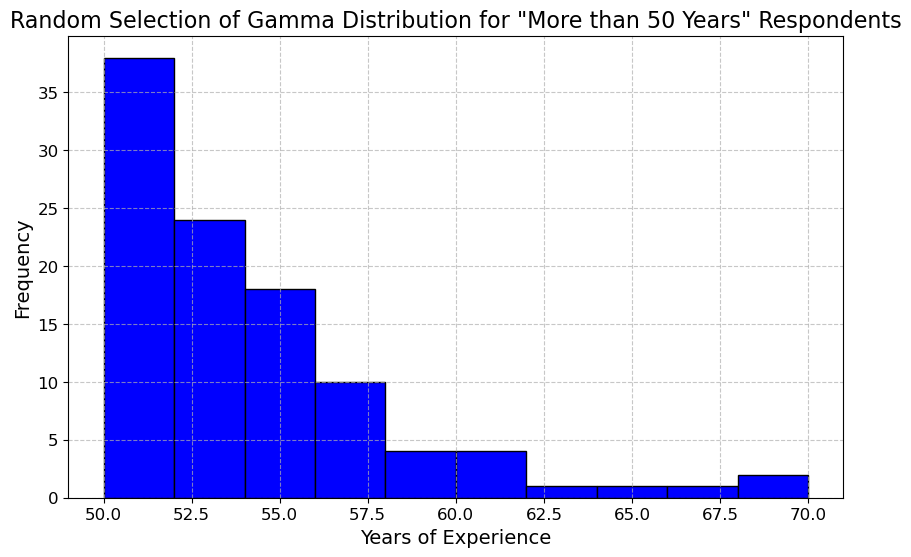

In [59]:
# create new values for 'more than 50 years' response
# ensuring that the number of gamma values is equal to the number of respondents who had 'More than 50 years'
# output them
more_than_50_new_values = generate_and_scale_distribution(random.gammavariate,(1,1),
                                                          len(earnings_data[earnings_data['YearsCode']=='More than 50 years'])
                                                          ,50,70,30)
plot_histogram(more_than_50_new_values,10,'Random Selection of Gamma Distribution for "More than 50 Years" Respondents','Years of Experience','Frequency')

In [60]:
# allocate the new values to the old values 
# this is done so that YearsCode is now an 'int' data type
more_than_50_old_values = earnings_data['YearsCode']=='More than 50 years'
earnings_data.loc[more_than_50_old_values, 'YearsCode'] = more_than_50_new_values

In [61]:
# replace less than 1 year with 1 year of experience
less_than_1_old_values = earnings_data['YearsCode'] == 'Less than 1 year'
earnings_data.loc[less_than_1_old_values,'YearsCode'] = 1

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_33707/2465112585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_data['YearsCode'] = earnings_data['YearsCode'].dropna().astype(int)


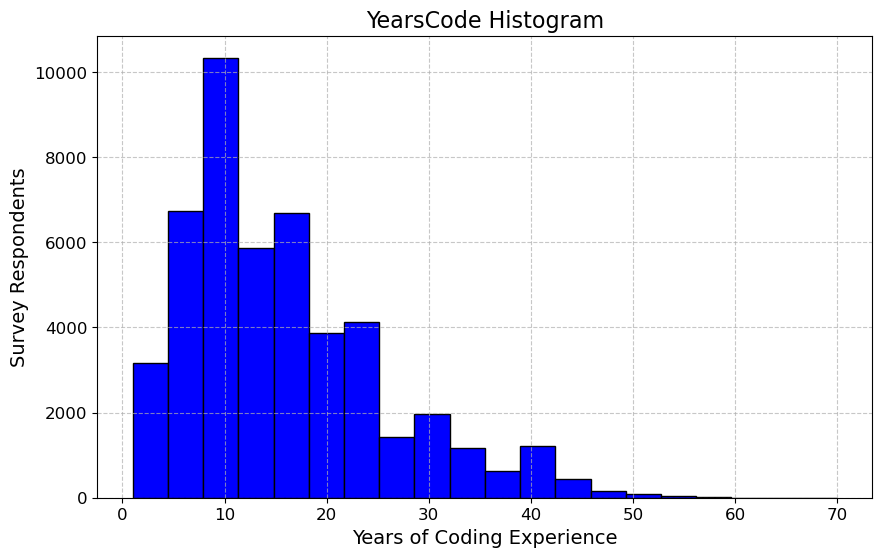

In [62]:
# change the datatype to int
# dropping the na when changing to int allows to not have to remove all NA
# this ensures data integrity
earnings_data['YearsCode'] = earnings_data['YearsCode'].dropna().astype(int)

# plot histogram
plot_histogram(earnings_data['YearsCode'],20,'YearsCode Histogram','Years of Coding Experience','Survey Respondents')

The data looks to have uniform distribution or gamma distribution, fit the data to those distributions to see which has a lower error value.

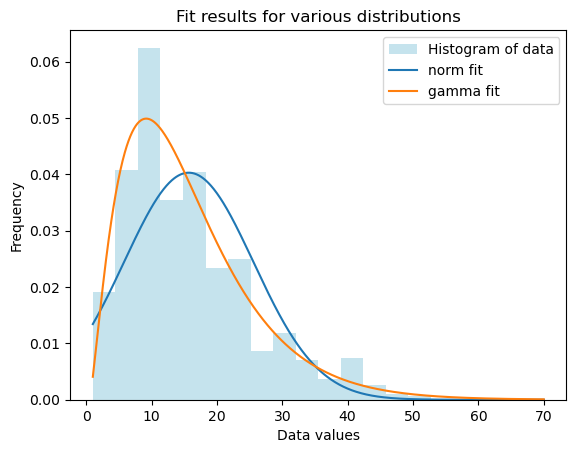

{'norm': 0.00460409547891067, 'gamma': 0.0028768146982904464}

In [63]:
# fit the YearsCode data with a given PDF
from scipy.stats import uniform
fit_and_plot_distributions(earnings_data['YearsCode'].dropna(),[norm,gamma],20) 

YearsPro data fits a gamma distribution by the values that have been produced and the movement of the data in the graph.

##### YearsCodePro

In [64]:
# understand the different outcomes
earnings_data['YearsCodePro'].unique()

array(['9', '23', '7', '4', '21', '3', '15', 'Less than 1 year', '10',
       '2', '6', '14', '5', '19', '13', '16', '28', '30', '11', '8', '24',
       '40', '17', '29', '25', '12', '20', '18', '50', '27', '43', '26',
       '1', '38', '33', '22', '35', nan, '31', '34', '32', '37', '42',
       'More than 50 years', '36', '39', '41', '44', '48', '45', '46',
       '47', '49'], dtype=object)

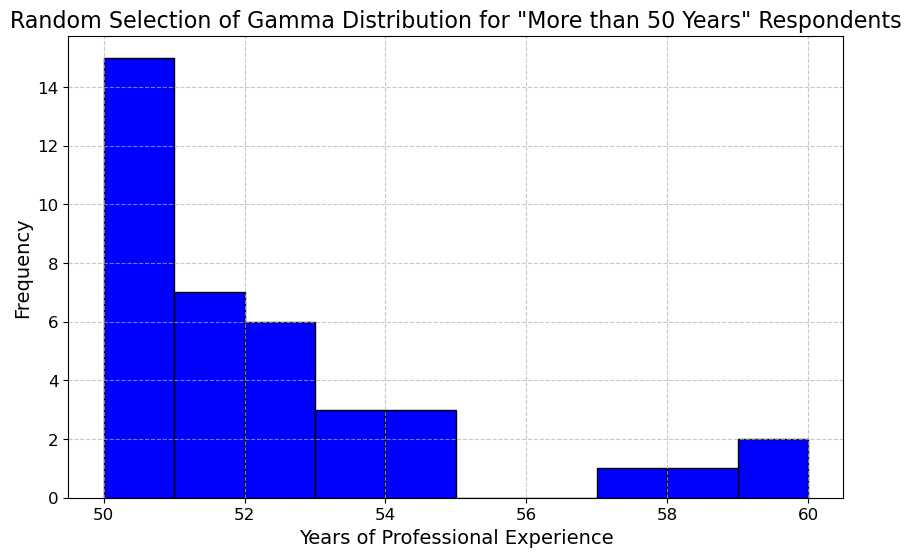

In [65]:
# create new values for 'more than 50 years' response
# a maximum of 60 years of professional coding has been put on the data to accurately reflect reality
more_than_50_new_values_pro = generate_and_scale_distribution(random.gammavariate,(1,1),
                                                          len(earnings_data[earnings_data['YearsCodePro']=='More than 50 years'])
                                                          ,50,60,30)
plot_histogram(more_than_50_new_values_pro,10,'Random Selection of Gamma Distribution for "More than 50 Years" Respondents','Years of Professional Experience','Frequency')

In [66]:
# allocate the new values to the old values 
# this is done so that YearsCode is now an 'int' data type
more_than_50_old_values_pro = earnings_data['YearsCodePro']=='More than 50 years'
earnings_data.loc[more_than_50_old_values_pro, 'YearsCodePro'] = more_than_50_new_values_pro

In [67]:
# replace less than 1 year with 1 year of experience
less_than_1_old_values_pro = earnings_data['YearsCodePro'] == 'Less than 1 year'
earnings_data.loc[less_than_1_old_values_pro,'YearsCodePro'] = 1

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_33707/2853971813.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_data['YearsCodePro'] = earnings_data['YearsCodePro'].dropna().astype(int)


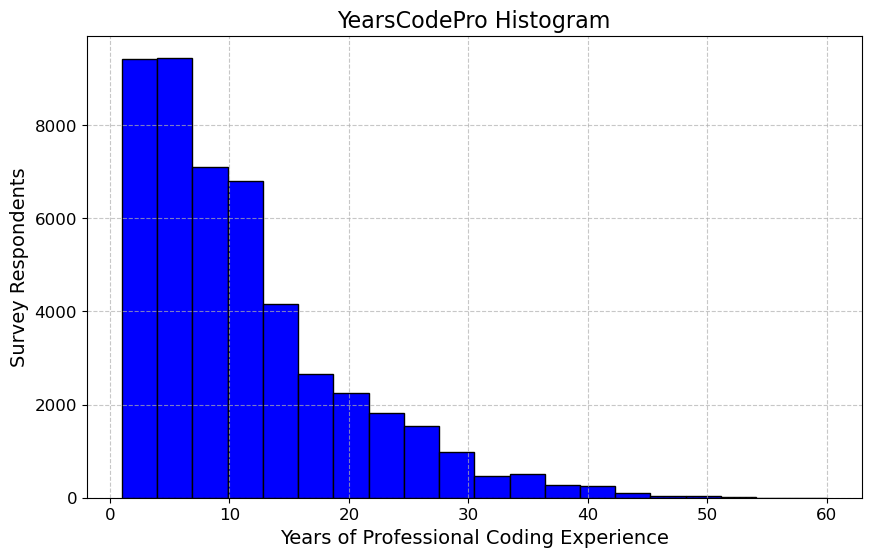

In [68]:
# change the datatype to int
# dropping the na when changing to int allows to not have to remove all NA
# this ensures data integrity
earnings_data['YearsCodePro'] = earnings_data['YearsCodePro'].dropna().astype(int)

# plot histogram
plot_histogram(earnings_data['YearsCodePro'],20,'YearsCodePro Histogram','Years of Professional Coding Experience','Survey Respondents')

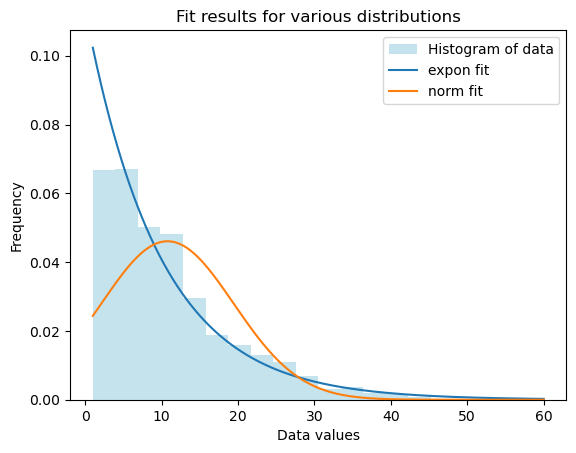

{'expon': 0.002717367940146757, 'norm': 0.006419788993686955}

In [69]:
# fit the data to different distributions
fit_and_plot_distributions(earnings_data['YearsCodePro'].dropna(),[expon,norm],20) 

In [70]:
linear_regression_data_salary

,EdLevel,YearsCodePro,YearsCode,OrgSize,Country,ConvertedCompYearly,Not-DevType,DevType,Engineering and Operations,Management and Leadership,Others,Software Developer,Not-Industry,Industry,Healthcare,Higher Education,"Information Services, IT, Software Development, or other Technology",Insurance,Legal Services,"Manufacturing, Transportation, or Supply Chain",Oil & Gas,Other,Retail and Consumer Services,Wholesale
ResponseId,,,,,,,,,,,,,,,,,,,,,,,,
2,NaN,9,18,2.0,1,285000.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,NaN,23,27,8.0,1,250000.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,NaN,7,12,5.0,1,156000.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,NaN,4,6,4.0,0,23456.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
6,NaN,21,21,5.0,0,96828.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89163,NaN,24,30,8.0,0,50719.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
89167,NaN,2,7,4.0,0,16917.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
89168,NaN,2,6,4.0,0,15752.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


YearsCodePro fits the distribution of exponential the best.

In [71]:
import ISLP
X = linear_regression_data_salary.drop(columns='ConvertedCompYearly').fit_transform()

AttributeError: 'DataFrame' object has no attribute 'fit_transform'

In [ ]:
# rename column
earnings_data.rename(columns={'ConvertedCompYearly':'Salary'},inplace=True)

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_63159/3143130971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  earnings_data.rename(columns={'ConvertedCompYearly':'Salary'},inplace=True)


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff1d27c2310>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff1d27c28b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff1d27c2040>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff1d27c2e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff1d27cc160>],
 'means': []}

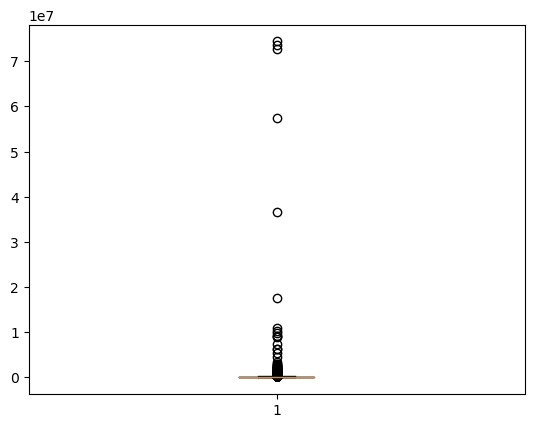

In [ ]:
# create a histogram for earners
plt.boxplot(earnings_data['Salary'])

In [ ]:
# calculate the mean and the median
mean_salary = earnings_data['Salary'].mean()
median_salary = earnings_data['Salary'].median()

# display the mean and median
print(f'The mean salary for respondents is {mean_salary}')
print(f'The median salary for the respondents is {median_salary}')

The mean salary for respondents is 103110.08171765343
The median salary for the respondents is 74963.0


There is clearly some outliers that are making the interpretation of the data difficult. This is further proved by the mean salary being about $25k more than the median salary. Removing this data will make for a better overall understanding of the survey respondents.

Remove those earning more than $10 million a year and those earning less than $20k a year

In [ ]:
# remove the extremely high earning individuals
low_earnings_mask = earnings_data['Salary'] < 20000
high_earnings_mask = earnings_data['Salary'] > 10000000

# use both masks to remove those earning less than $20k and those earning more than $10m
extreme_earnings = low_earnings_mask | high_earnings_mask

# remove the extreme earnings value
earnings_data = earnings_data[~extreme_earnings]

In [ ]:
earnings_data.corr()

,YearsCodePro,YearsCode,Salary
YearsCodePro,1.000000,0.911018,0.131529
YearsCode,0.911018,1.000000,0.125669
Salary,0.131529,0.125669,1.000000


#### Highest Earners
Looking at the top 0.03% of respondents based on salary using z-scores of at least 3.